In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot
from scipy import linalg
from numpy import ma

### Things to note
* MSE could have entirely different trajectory depending on initialization (on a single example, random initialization, MSE looks different every time I ran the model)

### Data Generation

In [2]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9, -.8], [-.5, -.3]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.6, .4])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = .1
        self.noise_1 = 1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.5, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.3, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        #np.random.seed(0)
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            self.plot_trajectory(n)
            self.pct_missing(n)

In [16]:
%%capture
model = Model(50, 20, 0.0)
model.run_simulation()

In [17]:
%%time
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = .8, single_effect=False)
num_iter = em.run_EM(5000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
17 iterations before loglik converges
CPU times: user 1.59 s, sys: 7.98 ms, total: 1.6 s
Wall time: 1.59 s


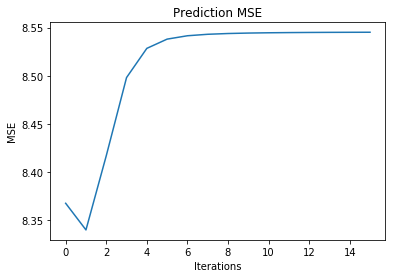

In [18]:
time = [i for i in range(len(em.mse))]
plt.plot(time, em.mse)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE')
plt.show()

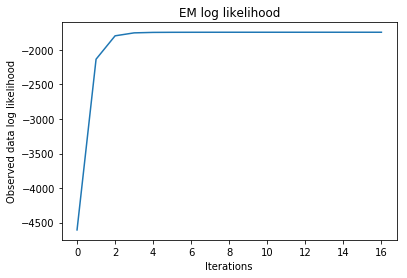

In [19]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

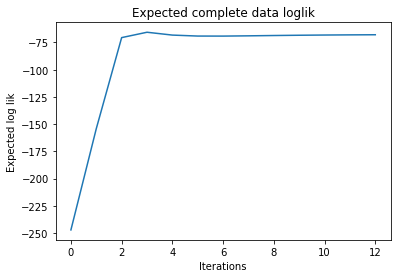

In [7]:
time = [i for i in range(len(em.expected_log_lik))]
plt.plot(time, em.expected_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Expected log lik')
plt.title('Expected complete data loglik')
plt.show()

In [8]:
em.expected_log_lik

[array([-247.03173785]),
 array([-154.13404591]),
 array([-70.59638654]),
 array([-65.67051558]),
 array([-68.27971408]),
 array([-69.17135775]),
 array([-69.206574]),
 array([-68.96338073]),
 array([-68.67694524]),
 array([-68.42582799]),
 array([-68.22716998]),
 array([-68.07703904]),
 array([-67.96607229])]

In [9]:
def mapd(actual, pred):
    return np.average(np.abs((actual-pred)/actual)) * 100

print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('mean absolute percentage difference of A: {}'.format(mapd(model.A, em.A)))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('mean absolute percentage difference of b: {}'.format(mapd(model.b, em.b)))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('mean absolute percentage difference of initial state mean: {}'.format(mapd(model.init_z, em.init_z)))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('mean absolute percentage difference of initial state variance: {}'.format(mapd(model.noise_0, em.sigma_0)))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('mean absolute percentage difference of transition variance: {}'.format(mapd(model.noise_1, em.sigma_1)))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('mean absolute percentage difference of observation variance: {}'.format(mapd(model.noise_2, em.sigma_2)))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated A: [[0. 0.]
 [0. 0.]]
true A: [[-0.9 -0.8]
 [-0.5 -0.3]]
mean absolute percentage difference of A: 100.0
estimated b: [0. 0.]
true b: [0.6 0.4]
mean absolute percentage difference of b: 100.0
estimated initial state mean: [0.10539265]
true initial state mean: 6
mean absolute percentage difference of initial state mean: 98.24345589250024
estimated sigma_0: 0.06397533911368229
true sigma_0: 0.1
mean absolute percentage difference of initial state variance: 36.02466088631771
estimated sigma_1: 1.4710373156104875
true sigma_1: 1
mean absolute percentage difference of transition variance: 47.10373156104875
estimated sigma_2: 2.895265557044682
true sigma_2: 0.01
mean absolute percentage difference of observation variance: 28852.655570446826
estimated ratio: 0.5080837272529972
true ratio: 100.0


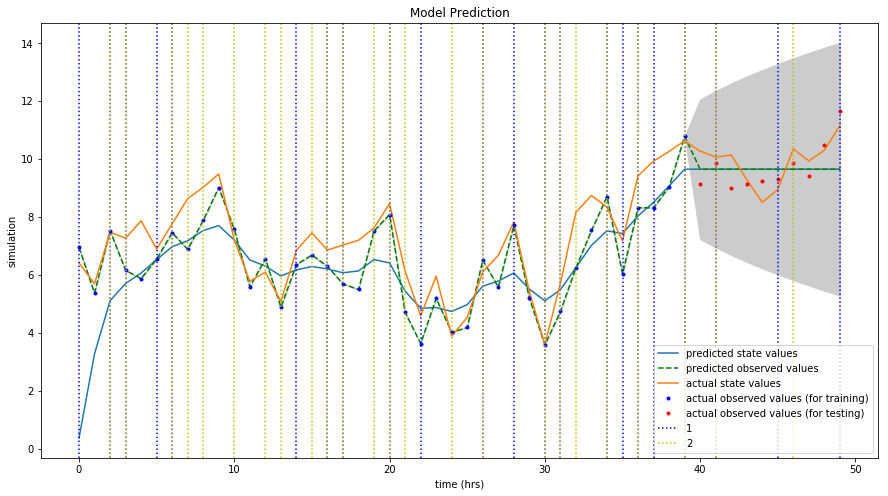

In [10]:
for n in range(model.y.shape[0]):
    plot(em, n, time_unit=1, true_model=True, model=model, signal_name='simulation', treatment_types=['1', '2'])

In [11]:
#measurements = ma.asarray(model.y)
#measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked
measurements = ma.asarray(model.y)
measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked

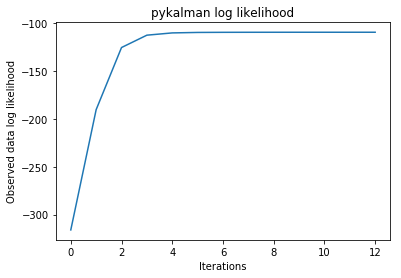

In [12]:
from pykalman import KalmanFilter
X = np.transpose(measurements)
kf = KalmanFilter(transition_matrices = 1, observation_matrices = 1, initial_state_covariance=em.init_0, initial_state_mean=em.init_state, transition_covariance=em.init_1, observation_covariance=em.init_2)
kf = kf.em(X, n_iter=num_iter, em_vars=['transition_covariance', 'observation_covariance'])

time = [i for i in range(len(kf.loglik))]
plt.plot(time, kf.loglik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('pykalman log likelihood')
plt.show()

In [13]:
kf.transition_covariance

array([[1.1869339]])

In [14]:
kf.observation_covariance

array([[2.3383415]])

### Last Observation Carry Forward

In [15]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

sigma_filter appears to converge to a value for all t > $t_0$. This replicates the updates equations, where y represents sigma_pred, x represents kgain, z represents sigma_filter. Following iterations, z always converges to one of the roots of the polynomial z^2 + a*z -a*b.